# Aim of assignment
Predict the sentiment by Tweets

# 1)- Importing key libraries 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os, string, collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import utils
from utils import *

import snowballstemmer
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [3]:
# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

## 2)- Loading & exploring data

In [4]:
Tweet=pd.read_csv("Airline-Sentiment-2-w-AA.csv",encoding='ISO-8859-1')

In [5]:
Tweet.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada)
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
2,681448156,False,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/15 11:15,5.703010e+17,Lets Play,Central Time (US & Canada)
3,681448158,False,finalized,3,2/25/15 3:05,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
4,681448159,False,finalized,3,2/25/15 5:50,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/15 11:14,5.703010e+17,NaN,Pacific Time (US & Canada)


In [6]:
Tweet.shape

(14640, 20)

In [7]:
len(Tweet)

14640

In [8]:
(len(Tweet)-Tweet.count())/len(Tweet)

_unit_id                        0.000000
_golden                         0.000000
_unit_state                     0.000000
_trusted_judgments              0.000000
_last_judgment_at               0.003825
airline_sentiment               0.000000
airline_sentiment:confidence    0.000000
negativereason                  0.373087
negativereason:confidence       0.281284
airline                         0.000000
airline_sentiment_gold          0.997268
name                            0.000000
negativereason_gold             0.997814
retweet_count                   0.000000
text                            0.000000
tweet_coord                     0.930396
tweet_created                   0.000000
tweet_id                        0.000000
tweet_location                  0.323292
user_timezone                   0.329235
dtype: float64

In [9]:
del Tweet['tweet_coord']
del Tweet['airline_sentiment_gold']
del Tweet['negativereason_gold']

In [10]:
Tweet['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

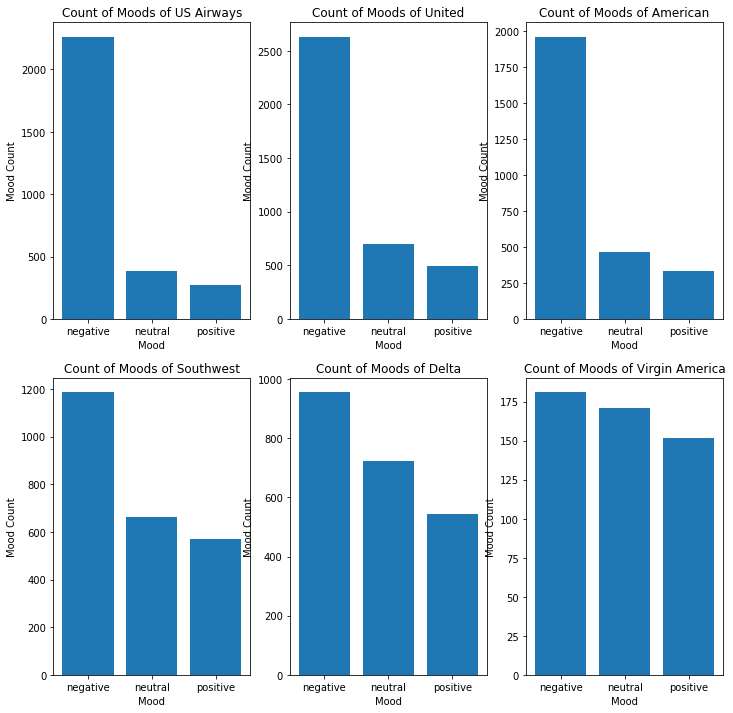

In [11]:
def plot_sub_sentiment(Airline):
    df=Tweet[Tweet['airline']==Airline]
    count=df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count)
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+Airline)
plt.figure(1,figsize=(12, 12))
plt.subplot(231)
plot_sub_sentiment('US Airways')
plt.subplot(232)
plot_sub_sentiment('United')
plt.subplot(233)
plot_sub_sentiment('American')
plt.subplot(234)
plot_sub_sentiment('Southwest')
plt.subplot(235)
plot_sub_sentiment('Delta')
plt.subplot(236)
plot_sub_sentiment('Virgin America')

From the above plots one can find that the distribution of moods for the first three airlines are always skewed toward negative moods. On contrary, the moods are distributed more balanced with the later three airline companies.

###  Reasons of negative sentiments

In [12]:
Tweet['negativereason'][4]

"Can't Tell"

In [13]:
Tweet['negativereason'].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [14]:
NR_Count=dict(Tweet['negativereason'].value_counts(sort=False))

In [15]:
def NR_Count(Airline):
    if Airline=='All':
        df=Tweet
    else:
        df=Tweet[Tweet['airline']==Airline]
    count=dict(df['negativereason'].value_counts())
    Unique_reason=list(Tweet['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame

In [16]:
def plot_reason(Airline):
    df=NR_Count(Airline)
    count=df['count']
    Index = range(1,(len(df)+1))
    plt.bar(Index,count)
    plt.xticks(Index,df['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)

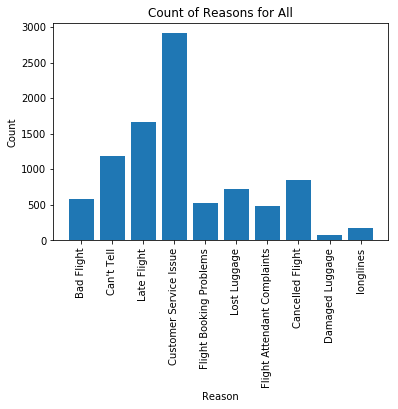

In [17]:
plot_reason('All')

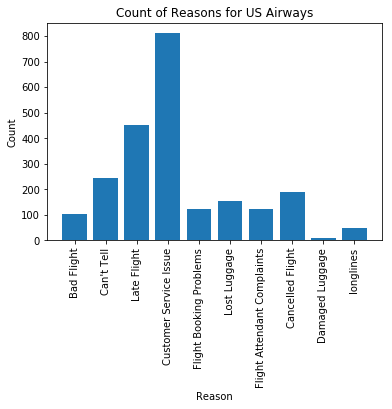

In [18]:
plot_reason('US Airways')

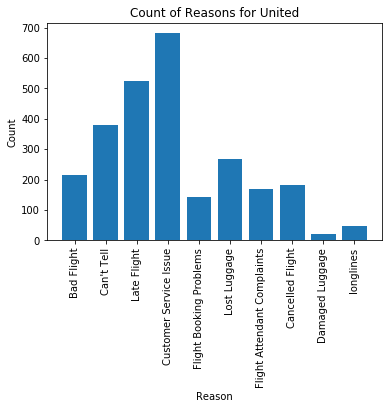

In [19]:
plot_reason('United')

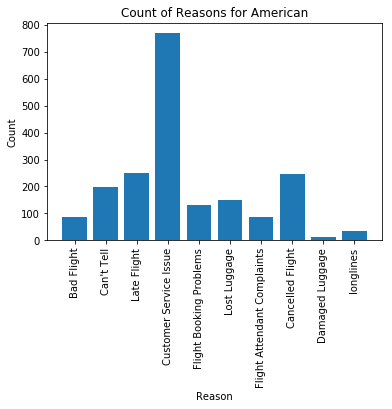

In [20]:
plot_reason('American')

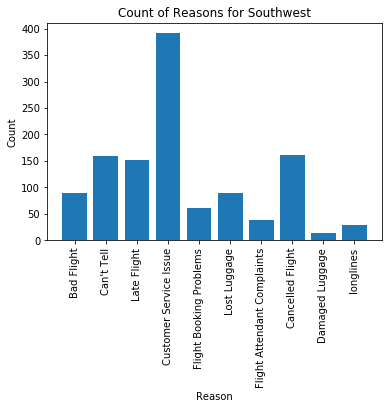

In [21]:
plot_reason('Southwest')

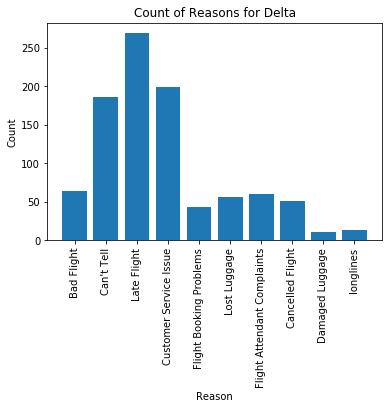

In [22]:
plot_reason('Delta')

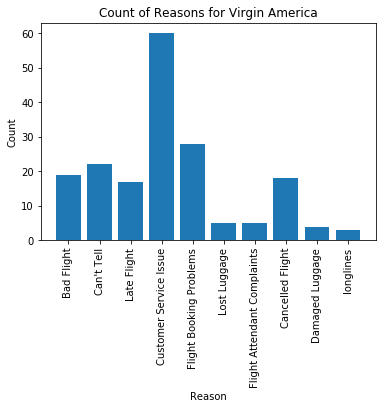

In [23]:
plot_reason('Virgin America')

In [24]:
df=pd.read_csv("Airline-Sentiment-2-w-AA.csv",encoding='ISO-8859-1')

In [25]:
df=df[['airline_sentiment','text']]

In [26]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [27]:
len(df)

14640

In [28]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

Text(0.5,1,'Value Count of Sentiments')

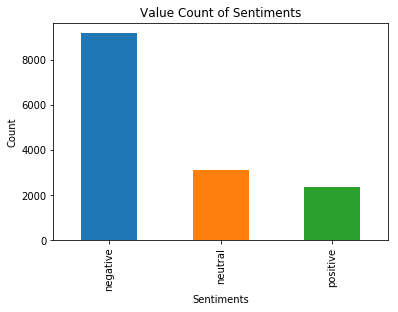

In [29]:
df['airline_sentiment'].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.xlabel('Sentiments')
plt.title('Value Count of Sentiments')

In [30]:
from wordcloud import WordCloud,STOPWORDS

In [31]:
df_tweet=df[df['airline_sentiment']=='negative']
words = ' '.join(df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [32]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

# 3)- Parameters defined 

In [33]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent

# 4)-Data Preprocessing

### a)- visualize 

In [34]:
from wordcloud import WordCloud,STOPWORDS

In [35]:
df_tweet_neg=df[df['airline_sentiment']=='negative']
words = ' '.join(df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [36]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

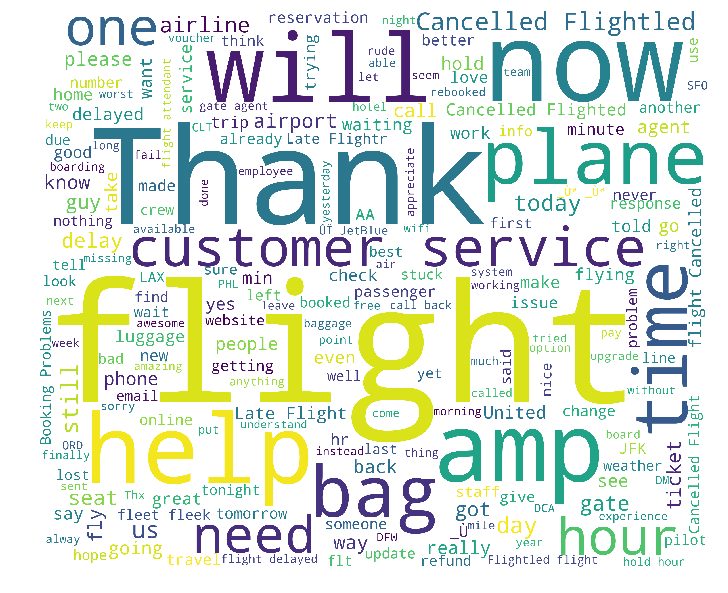

In [37]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### b)-Text cleaning

In [38]:
tc = TextCleaner()
df['clean_text'] = tc.transform(df['text'])

Tokenization

In [39]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

In [40]:
df['tokenized'] = df['clean_text'].apply(lambda row: tokenize(row))

In [41]:
df.head()

,airline_sentiment,text,clean_text,tokenized
0,neutral,@VirginAmerica What @dhepburn said.,what said,"[what, said]"
1,positive,@VirginAmerica plus you've added commercials t...,plus youve added commercials to the experience...,"[plus, youve, added, commercials, to, the, exp..."
2,neutral,@VirginAmerica I didn't today... Must mean I n...,i didnt today must mean i need to take another...,"[i, didnt, today, must, mean, i, need, to, tak..."
3,negative,@VirginAmerica it's really aggressive to blast...,its really aggressive to blast obnoxious enter...,"[its, really, aggressive, to, blast, obnoxious..."
4,negative,@VirginAmerica and it's a really big bad thing...,and its a really big bad thing about it,"[and, its, a, really, big, bad, thing, about, it]"


Stopwords removing

In [42]:
stop = set(stopwords.words('english'))
stop.update(['amp', 'rt', 'cc'])
stop = stop - set(['no', 'not'])

In [43]:
def remove_stopwords(row):
    return [t for t in row if t not in stop]

In [44]:
df['tokenized'] = df['tokenized'].apply(lambda row: remove_stopwords(row))

In [45]:
df[['text', 'tokenized']].head()

,text,tokenized
0,@VirginAmerica What @dhepburn said.,[said]
1,@VirginAmerica plus you've added commercials t...,"[plus, youve, added, commercials, experience, ..."
2,@VirginAmerica I didn't today... Must mean I n...,"[didnt, today, must, mean, need, take, another..."
3,@VirginAmerica it's really aggressive to blast...,"[really, aggressive, blast, obnoxious, enterta..."
4,@VirginAmerica and it's a really big bad thing...,"[really, big, bad, thing]"


 **in one step**

In [46]:
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
       
df['text_clean'] = df.text.apply(remove_stopwords).apply(remove_mentions)

In [47]:
df.head()

,airline_sentiment,text,clean_text,tokenized,text_clean
0,neutral,@VirginAmerica What @dhepburn said.,what said,[said],What said.
1,positive,@VirginAmerica plus you've added commercials t...,plus youve added commercials to the experience...,"[plus, youve, added, commercials, experience, ...",plus added commercials experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I n...,i didnt today must mean i need to take another...,"[didnt, today, must, mean, need, take, another...",today... Must mean need take another trip!
3,negative,@VirginAmerica it's really aggressive to blast...,its really aggressive to blast obnoxious enter...,"[really, aggressive, blast, obnoxious, enterta...","really aggressive blast obnoxious ""entertainm..."
4,negative,@VirginAmerica and it's a really big bad thing...,and its a really big bad thing about it,"[really, big, bad, thing]",really big bad thing


### d)-Train, test split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df.airline_sentiment, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 13176
# Test data samples: 1464


### e)-Converting words to numbers

In [49]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 13176 documents
10000 words in dictionary
Top 5 most common words are: [('to', 7766), ('the', 5496), ('i', 4834), ('a', 4345), ('you', 4116)]


### f)-text_to_sequences
After having created the dictionary we can convert the text to a list of integer indexes. This is done with the text_to_sequences method of the Tokenizer.

In [50]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

print('"{}" is converted into {}'.format(X_train[0], X_train_seq[0]))

"what said" is converted into [5, 715, 13, 996, 10, 111, 47, 23, 363, 15, 18, 1817, 26, 5, 115, 1155, 15, 90, 2691, 14, 12, 4]


### g)-one-hot encoded features

In [51]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

print('"{}" is converted into {}'.format(X_train_seq[0], X_train_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_train_oh[0].sum()))

"[5, 715, 13, 996, 10, 111, 47, 23, 363, 15, 18, 1817, 26, 5, 115, 1155, 15, 90, 2691, 14, 12, 4]" is converted into [0. 0. 0. ... 0. 0. 0.]
For this example we have 20.0 features with a value of 1.


### h)-Converting the target classes to numbers
We need to convert the target classes to numbers as well, which in turn are one-hot-encoded with the to_categorical method in keras

In [52]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"neutral" is converted into 0
"0" is converted into [1. 0. 0.]


### i)-Splitting of a validation set

In [53]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (1318, 10000)


# 5)- Model

In [54]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [55]:
def deep_model(model):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return history

In [56]:
base_history = deep_model(base_model)

Instructions for updating:
Use tf.cast instead.


### evaluate the model

In [57]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

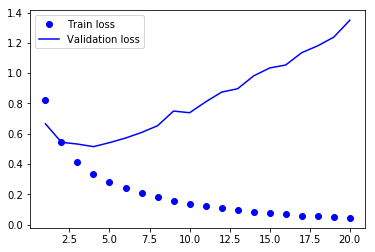

In [58]:
eval_metric(base_history, 'loss')

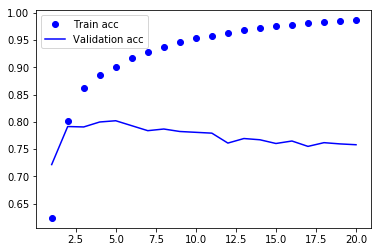

In [59]:
eval_metric(base_history, 'acc')

Clearly, we have problem of overfitting

# 6)- Overfitting Handling

Option 1: reduce the network's size by removing layers or reducing the number of hidden elements in the layers
    
Option 2: add regularization, which comes down to adding a cost to the loss function for large weights
    
Option 3: adding dropout layers, which will randomly remove certain features by setting them to zero

### 6.1)-Reducing the network's size

In [60]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(32, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 320,131
Trainable params: 320,131
Non-trainable params: 0
_________________________________________________________________


In [61]:
reduced_history = deep_model(reduced_model)

In [62]:
def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()

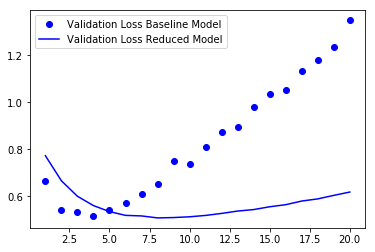

In [63]:
compare_loss_with_baseline(reduced_history, 'Reduced Model')

### 6.2)-Adding regularization

In [64]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [65]:
reg_history = deep_model(reg_model)

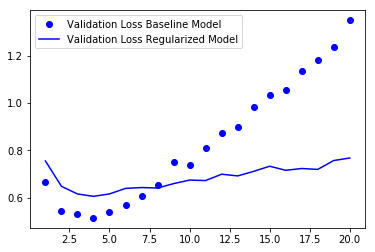

In [66]:
compare_loss_with_baseline(reg_history, 'Regularized Model')

### 6.3)-Adding dropout layers

In [67]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                640064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [68]:
drop_history = deep_model(drop_model)

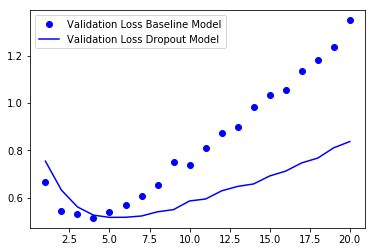

In [69]:
compare_loss_with_baseline(drop_history, 'Dropout Model')

# 7)-Training on the full train data and evaluation on test data

In [70]:
def test_model(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test_oh, y_test_oh)
    
    return results

In [71]:
base_results = test_model(base_model, 4)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[1]*100))

1464/1464 [==============================] - 0s 118us/step
/n
Test accuracy of baseline model: 77.46%


In [72]:
reduced_results = test_model(reduced_model, 10)
print('/n')
print('Test accuracy of reduced model: {0:.2f}%'.format(reduced_results[1]*100))

1464/1464 [==============================] - 0s 83us/step
/n
Test accuracy of reduced model: 79.64%


In [73]:
reg_results = test_model(reg_model, 5)
print('/n')
print('Test accuracy of regularized model: {0:.2f}%'.format(reg_results[1]*100))

1464/1464 [==============================] - 0s 119us/step
/n
Test accuracy of regularized model: 78.83%


In [74]:
drop_results = test_model(drop_model, 6)
print('/n')
print('Test accuracy of dropout model: {0:.2f}%'.format(drop_results[1]*100))

1464/1464 [==============================] - 0s 97us/step
/n
Test accuracy of dropout model: 80.19%
